# Project 2 - Ames Housing Data and Kaggle Challenge


## Problem Statement 
---

AgentAmes.com is a popular property website that connects buyers and sellers in the Ames property market. A recent focus group conducted
by the marketing team surfaced the top pain-point experienced by users is that they have no idea how to price their property on the platform.
This has resulted in sellers not getting bids for their property listings and many have resulted in shunning the platform altogether.
Therefore, the management team has tasked the tech team to leverage this consumer insight by creating a regression model that can be
built into the platform to help users gauge the sale price of their properties to reduce the gap between seller's and buyer's price expectations.



## Data Cleaning and EDA

---

### Data Dictionary

---
For detailed information on the dataset, please review the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

In [155]:
#importing the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


### Data Cleaning

In [156]:
#reading in the train dataset

df = pd.read_csv("./datasets/train.csv")

In [157]:
#getting an overview on the number of null values and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

#### Dropping columns with high null counts 
After consulting the table above, we will proceed to drop "Alley", "Pool QC" and "Misc Feature"
as more than 90% of the it are null values. With reference to the data documentation. We understand
that the majority of the null values here are not missing values, instead they usually represent that
particular feature in not available. So in the case of "Alley", there are only 140 non-null count,
meaning only 140 (less than 7%) of the houses have some sort alley access to the property. So we will
drop the 3 features as they will not be helpful in our regression model.

In [158]:
df.drop(["Alley","Pool QC", "Misc Feature"],axis=1, inplace = True)

#### Dropping outliers as described by data documentation

With reference from the data documentation it is recommended that we remove the outliers in the dataset,
the outliers are described as any house with more than 4000 square feet.

In [159]:
#Locating the outlier rows

df.loc[df['Gr Liv Area'] > 4000, ['Gr Liv Area']]

,Gr Liv Area
960,5642
1885,5095


In [160]:
df.drop([960,1885], axis=0, inplace=True)

In [161]:
# Checking that 3 columns and 2 rows have been dropped

df.shape

(2049, 78)

#### Identifying and Cleaning Null Values

In [162]:
#creating the list of features

features = [x for x in df.columns]

In [163]:
#Identify the remaining columns with null values

null_feat = [x for x in features if df[x].isnull().sum() != 0]
print(f' There are {len(null_feat)} features with null values.')
print(null_feat)

 There are 23 features with null values.
['Lot Frontage', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Fence']


We will process the null values in groups as some of the features are related to each other:

1) 'Lot Frontage'
2) 'Mas Vnr Type', 'Mas Vnr Area'
3) 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 
   'BsmtFin Type 1', 'BsmtFin Type 2',
4) 'BsmtFin SF 1', 'BsmtFin SF 2',
   'Bsmt Unf SF', 'Total Bsmt SF'
4) 'Bsmt Full Bath', 'Bsmt Half Bath'
5) 'Fireplace Qu'
6) 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 
   'Garage Cars', 'Garage Area', 
   'Garage Qual', 'Garage Cond'
7) 'Fence'

In [164]:
df['Lot Frontage'].isnull().sum()

330



Imputing null values in 'Lot Frontage' with 0.0 as we assume for these properties
there are 0.0 linear feet of the street connected to the property


In [165]:
df["Lot Frontage"].fillna(0.0, inplace = True)
df['Lot Frontage'].isnull().sum()

0

With reference to the data description, null values found in 'Mas Vnr Type' & 'Mas Vnr Area'
may be attributed to the value "None" given to rows with no masonry veneer type

In [166]:
# The null values in both columns occur in the same 22 rows

df[["Mas Vnr Type","Mas Vnr Area"]][(df["Mas Vnr Type"].isnull() == True) & (df["Mas Vnr Area"].isnull() == True)]

,Mas Vnr Type,Mas Vnr Area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN
338,NaN,NaN
431,NaN,NaN
451,NaN,NaN
591,NaN,NaN
844,NaN,NaN


In [167]:
df["Mas Vnr Type"].value_counts()

None       1218
BrkFace     630
Stone       166
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

Value count reveals that most properties with no masonary veneer type were properly recorded as "None" in the "Mas Vnr Type" column, we proceed to replace the 22 Rows with "NaN" with None and 0.0 respectively.

In [168]:

df["Mas Vnr Type"].fillna("None", inplace = True)
df["Mas Vnr Area"].fillna(0.0, inplace = True)

df[["Mas Vnr Type","Mas Vnr Area"]].isnull().sum()

Mas Vnr Type    0
Mas Vnr Area    0
dtype: int64

In [169]:
# Get the overview of null values in the nominal and ordinal basement features

basement_f = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']

df[basement_f].isnull().sum()

Bsmt Qual         55
Bsmt Cond         55
Bsmt Exposure     58
BsmtFin Type 1    55
BsmtFin Type 2    56
dtype: int64

We observe the number of null values are very similar in this group, we can check if most of
the null values exist in the same row and can be explained by the fact that there is no basement
in the property.

In [170]:
# With reference to 'Bsmt Qual'

df[basement_f][(df['Bsmt Qual'].isnull() ==  True)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 12 to 2010
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Bsmt Qual       0 non-null      object
 1   Bsmt Cond       0 non-null      object
 2   Bsmt Exposure   0 non-null      object
 3   BsmtFin Type 1  0 non-null      object
 4   BsmtFin Type 2  0 non-null      object
dtypes: object(5)
memory usage: 2.6+ KB


From the above, we can see that the 55 rows of null in basement features can be explained
by the fact that there is no basement in the property, we will replace "NaN" with "NoBase"
to represent no basement instead for these 55 rows.

In [171]:
df['Bsmt Qual'].fillna("NoBase", inplace = True)
df['Bsmt Cond'].fillna("NoBase", inplace = True)
df['BsmtFin Type 1'].fillna("NoBase", inplace = True)

Now we will proceed to identify the 3 null values in "Bsmt Exposure" not attributed to
no basement available in the property

In [172]:
df[basement_f][(df['Bsmt Exposure'].isnull() ==  True) & (df['Bsmt Qual'] !=  "NoBase")]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2
1456,Gd,TA,NaN,Unf,Unf
1547,Gd,TA,NaN,Unf,Unf
1997,Gd,TA,NaN,Unf,Unf


In [173]:
df['Bsmt Exposure'].value_counts()

No    1339
Av     288
Gd     201
Mn     163
Name: Bsmt Exposure, dtype: int64

In [174]:
df['Bsmt Qual'].value_counts()

TA        887
Gd        864
Ex        182
Fa         60
NoBase     55
Po          1
Name: Bsmt Qual, dtype: int64

We observe that there are only 55 property with no basement while 1339 property with no basement exposure. It will be reasonable to impute the 3 misssing values with the mode, which is "No" as the
large number of "No" in "Bsmt Exposure" is not attributed to the property no having a basement.

In [175]:
df['Bsmt Exposure'].mode()

0    No
Name: Bsmt Exposure, dtype: object

In [176]:
#Imputing the 3 missing values (where there is a basement on the property) with mode

df['Bsmt Exposure'] = np.where((df['Bsmt Qual'] != "NoBase") & 
                               (df['Bsmt Exposure'].isnull() == True), 
                               "No", df['Bsmt Exposure'])

In [177]:
#Impute the remaing 55 missing values with no basement

df['Bsmt Exposure'].fillna("NoBase", inplace = True)

Similarly for "BsmtFin Type 2", we observe 1 missing value not explained by the fact that there is
no basement on the property.

In [178]:
df[basement_f][(df['BsmtFin Type 2'].isnull() ==  True) & (df['Bsmt Qual'] !=  "NoBase")]


,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2
1147,Gd,TA,No,GLQ,NaN


In [179]:
df['BsmtFin Type 2'].mode()

0    Unf
Name: BsmtFin Type 2, dtype: object

In [180]:
#Imputing the 1 missing value (where there is a basement on the property) with mode

df['BsmtFin Type 2'] = np.where((df['Bsmt Qual'] != "NoBase") & 
                             (df['BsmtFin Type 2'].isnull() == True), 
                             "Unf", df['BsmtFin Type 2'])

In [181]:
#Impute the remaing 55 missing values with no basement

df['BsmtFin Type 2'].fillna("NoBase", inplace = True)

In [182]:
df[basement_f].isnull().sum()

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
dtype: int64

In [183]:
# Get the overview of null values in the continuous basement features
df[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']].isnull().sum()

BsmtFin SF 1     1
BsmtFin SF 2     1
Bsmt Unf SF      1
Total Bsmt SF    1
dtype: int64

In [184]:
# checking if missing values in these columns can be explained by there is no basement on the property
df[['Bsmt Qual','BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']][(df['BsmtFin SF 1'].isnull() == True)]

,Bsmt Qual,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
1327,NoBase,NaN,NaN,NaN,NaN


We observe that all the NaN value occur in the row where there is no basement,
will convert the NaN to 0.0 for the four columns

In [185]:
df['BsmtFin SF 1'].fillna(0.0, inplace = True)
df['BsmtFin SF 2'].fillna(0.0, inplace = True)
df['Bsmt Unf SF'].fillna(0.0, inplace = True)
df['Total Bsmt SF'].fillna(0.0, inplace = True)
df[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']].isnull().sum()

BsmtFin SF 1     0
BsmtFin SF 2     0
Bsmt Unf SF      0
Total Bsmt SF    0
dtype: int64

In [186]:
df[['Bsmt Full Bath', 'Bsmt Half Bath']].isnull().sum()

Bsmt Full Bath    2
Bsmt Half Bath    2
dtype: int64

In [187]:
# checking if missing values in these columns can be explained by there is no basement on the property
df[['Bsmt Qual','Bsmt Full Bath', 'Bsmt Half Bath']][(df['Bsmt Full Bath'].isnull() ==  True)]

,Bsmt Qual,Bsmt Full Bath,Bsmt Half Bath
616,NoBase,NaN,NaN
1327,NoBase,NaN,NaN


Similar to the above columns, we will impute with 0.0 

In [188]:
df['Bsmt Full Bath'].fillna(0.0, inplace = True)
df['Bsmt Half Bath'].fillna(0.0, inplace = True)
df[['Bsmt Full Bath', 'Bsmt Half Bath']].isnull().sum()

Bsmt Full Bath    0
Bsmt Half Bath    0
dtype: int64

In [189]:
df['Fireplaces'].value_counts()

0    1000
1     898
2     145
3       5
4       1
Name: Fireplaces, dtype: int64

Checking if there are any missing value in "Fireplace Qu" not attributed to no fireplace available ono the property

In [190]:
df[["Fireplaces","Fireplace Qu"]][(df["Fireplaces"] != 0) & (df["Fireplace Qu"].isnull() == True)]

,Fireplaces,Fireplace Qu


From the data documentation, similar to the basement data problem, properties with no fireplace
are assigned NaN, will replace with NoFP instead.

In [191]:
df['Fireplace Qu'].fillna("NoFP", inplace = True)
df['Fireplace Qu'].isnull().sum()

0

In [192]:
#checking the null values in the garagee features
garage_f = ['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']
df[garage_f].isnull().sum()

Garage Type      113
Garage Yr Blt    114
Garage Finish    114
Garage Cars        1
Garage Area        1
Garage Qual      114
Garage Cond      114
dtype: int64

In [193]:
# located the row where Garage type is not "NA" but is "NA" for the other garage related features.

df[garage_f][(df["Garage Type"].isnull() == False) & (df["Garage Yr Blt"].isnull() == True)]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
# Assume that this could be a data-entry error, impute Garage Type as NoGr to represent No Garage.

In [195]:

df['Garage Type'] = np.where((df['Garage Type'].isnull() == False) & 
                             (df['Garage Finish'].isnull() == True), 
                             "NoGr", df['Garage Type'])

In [196]:
df[garage_f][(df["Garage Type"].isnull() == False) & (df["Garage Yr Blt"].isnull() == True)]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1712,NoGr,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
#Imputing 0.0 for numerical feeatures

df["Garage Cars"].fillna(0.0, inplace = True)
df["Garage Area"].fillna(0.0, inplace = True)
df['Garage Yr Blt'].fillna(0.0, inplace = True)

In [198]:
#Imputing "NoGr"for non-numerical feeatures

df['Garage Type'].fillna("NoGr", inplace = True)
df['Garage Finish'].fillna("NoGr", inplace = True)
df['Garage Qual'].fillna("NoGr", inplace = True)
df['Garage Cond'].fillna("NoGr", inplace = True)


In [199]:
df[garage_f].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Garage Type    2049 non-null   object 
 1   Garage Yr Blt  2049 non-null   float64
 2   Garage Finish  2049 non-null   object 
 3   Garage Cars    2049 non-null   float64
 4   Garage Area    2049 non-null   float64
 5   Garage Qual    2049 non-null   object 
 6   Garage Cond    2049 non-null   object 
dtypes: float64(3), object(4)
memory usage: 128.1+ KB


In [200]:
# Again with reference from the data documentation, impute the NaN values as "NoFn"
# go represent no fence
df['Fence'].isnull().sum()

1649

In [201]:
df['Fence'].fillna("NoFn", inplace = True)

### Converting Data Types

Converting numerical values in "MS Subclass" to strings as the numbers are actually classification numbers.

In [202]:
df["MS SubClass"] = df["MS SubClass"].astype(str)

In [203]:
df["MS SubClass"].dtype

dtype('O')

Next we will be converting some columns with ordinal features from strings to integers so we can treat them as numerical features for processing later.


In [204]:
# Ex - 5, Gd - 4, TA - 3, Fa - 2, Po - 1, Nobase - 0, NoGr -0 , NoFP - 0
"Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond","Heating QC",
"Kitchen Qual","Garage Qual", "Garage Cond", "Fireplace Qu"

def map_to_num(dataframe,columns):
    
    for x in columns:
    
        dataframe[x] = dataframe[x].map({"Ex":5,
                                         "Gd":4,
                                         "TA":3,
                                         "Fa":2,
                                         "Po":1,
                                         "NoBase":0,
                                         "NoGr":0,
                                         "NoFP":0})
                                        

In [205]:
map_to_num(df,["Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond","Heating QC",
"Kitchen Qual","Garage Qual", "Garage Cond", "Fireplace Qu"])

In [206]:
# Gd - 4 Av - 3 Mn - 2 No - 1 NoBase - 0

df['Bsmt Exposure'] = df['Bsmt Exposure'].map({"Gd":4, 
                                               "Av":3, 
                                               "Mn":2, 
                                               "No":1, 
                                               "NoBase":0})

df["Bsmt Exposure"].value_counts()

1    1342
3     288
4     201
2     163
0      55
Name: Bsmt Exposure, dtype: int64

In [207]:
# GLQ -6 ALQ -5 BLQ -4 Rec -3 LwQ -2 Unf -1 NoBase -0

df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({"GLQ":6, 
                                               "ALQ":5, 
                                               "BLQ":4, 
                                               "Rec":3, 
                                               "LwQ":2, 
                                               "Unf":1, 
                                               "NoBase":0})

df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({"GLQ":6, 
                                               "ALQ":5, 
                                               "BLQ":4, 
                                               "Rec":3, 
                                               "LwQ":2, 
                                               "Unf":1, 
                                               "NoBase":0})



In [208]:
df['BsmtFin Type 1'].value_counts()

6    613
1    603
5    293
4    200
3    183
2    102
0     55
Name: BsmtFin Type 1, dtype: int64

In [209]:
df['BsmtFin Type 2'].value_counts()

1    1748
3      80
2      60
0      55
4      48
5      35
6      23
Name: BsmtFin Type 2, dtype: int64

In [210]:
# Changing year features to age

df[['Year Built','Year Remod/Add','Garage Yr Blt']].describe()

,Year Built,Year Remod/Add,Garage Yr Blt
count,2049.000000,2049.000000,2049.000000
mean,1971.673499,1984.166423,1868.590044
std,30.171293,21.032785,454.334478
min,1872.000000,1950.000000,0.000000
25%,1953.000000,1964.000000,1957.000000
50%,1974.000000,1993.000000,1978.000000
75%,2001.000000,2004.000000,2001.000000
max,2010.000000,2010.000000,2207.000000


In [211]:
# Problem with Garage Yr Blt, max value exceed current year

# locate problematic row with erroneous "Garage Yr Blt"

df[['Year Built','Year Remod/Add','Garage Yr Blt']][df['Garage Yr Blt'] > 2010]

,Year Built,Year Remod/Add,Garage Yr Blt
1699,2006,2007,2207.0


In [212]:
# Impute with 2007, same year a Remod/Add for that row

df['Garage Yr Blt'] = np.where((df['Garage Yr Blt'] == 2207), 2007, df['Garage Yr Blt'])

# Check if the value is imputed
df[['Year Built','Year Remod/Add','Garage Yr Blt']][df['Garage Yr Blt'] > 2010]

,Year Built,Year Remod/Add,Garage Yr Blt


In [213]:
# Engineering the 3 age columns for easier intepretation of features 

df["Prop Age"] = 2022 - df['Year Built']
df["Remod Age"] = 2022 - df['Year Remod/Add']
df["Garage Age"] = 2022 - df['Garage Yr Blt']

In [214]:
# drop the 3 "Years" feature since we have replaced them with the "Age" features

df.drop(columns = ['Year Built','Year Remod/Add','Garage Yr Blt'],axis = 1, inplace = True)


In [215]:
df.shape

(2049, 78)

### EDA

#### Selecting Numeric Features

In [216]:
#Extraction the numericsl features

exclude_list = ['Id','PID','Mo Sold','Yr Sold']

Numeric_F = [df.columns[i] for i in range(0,len(df.columns)) if df[df.columns[i]].dtype == "int64" or df[df.columns[i]].dtype == "float64"]

In [217]:
#Select Numeric Feature with absolute correlation score (with SalePrice) more than 0.5
Numeric_F = list((df.corr()["SalePrice"][abs(df.corr()["SalePrice"]) > 0.5]).index)

In [218]:
#drop numeric features with low correlation with "SalePrice"

drop_numeric_list = list((df.corr()["SalePrice"][abs(df.corr()["SalePrice"]) <= 0.5]).index)

In [219]:
df.drop(columns = drop_numeric_list,
                    axis = 1, inplace = True)

In [220]:
df.shape

(2049, 44)

In [221]:
df[Numeric_F].corr()["SalePrice"]

Overall Qual     0.803462
Mas Vnr Area     0.511273
Exter Qual       0.715048
Bsmt Qual        0.613236
Total Bsmt SF    0.665116
1st Flr SF       0.648252
Gr Liv Area      0.719463
Full Bath        0.538225
Kitchen Qual     0.694295
TotRms AbvGrd    0.509775
Fireplace Qu     0.539484
Garage Cars      0.648227
Garage Area      0.655097
SalePrice        1.000000
Prop Age        -0.572405
Remod Age       -0.550872
Name: SalePrice, dtype: float64

From the above series, we can see that we do have quite a good amount of numerical features with high correlation with the sale price which will help us in building the regression model. Next we will plot a heatmap to find any occurences of multicollinearity.

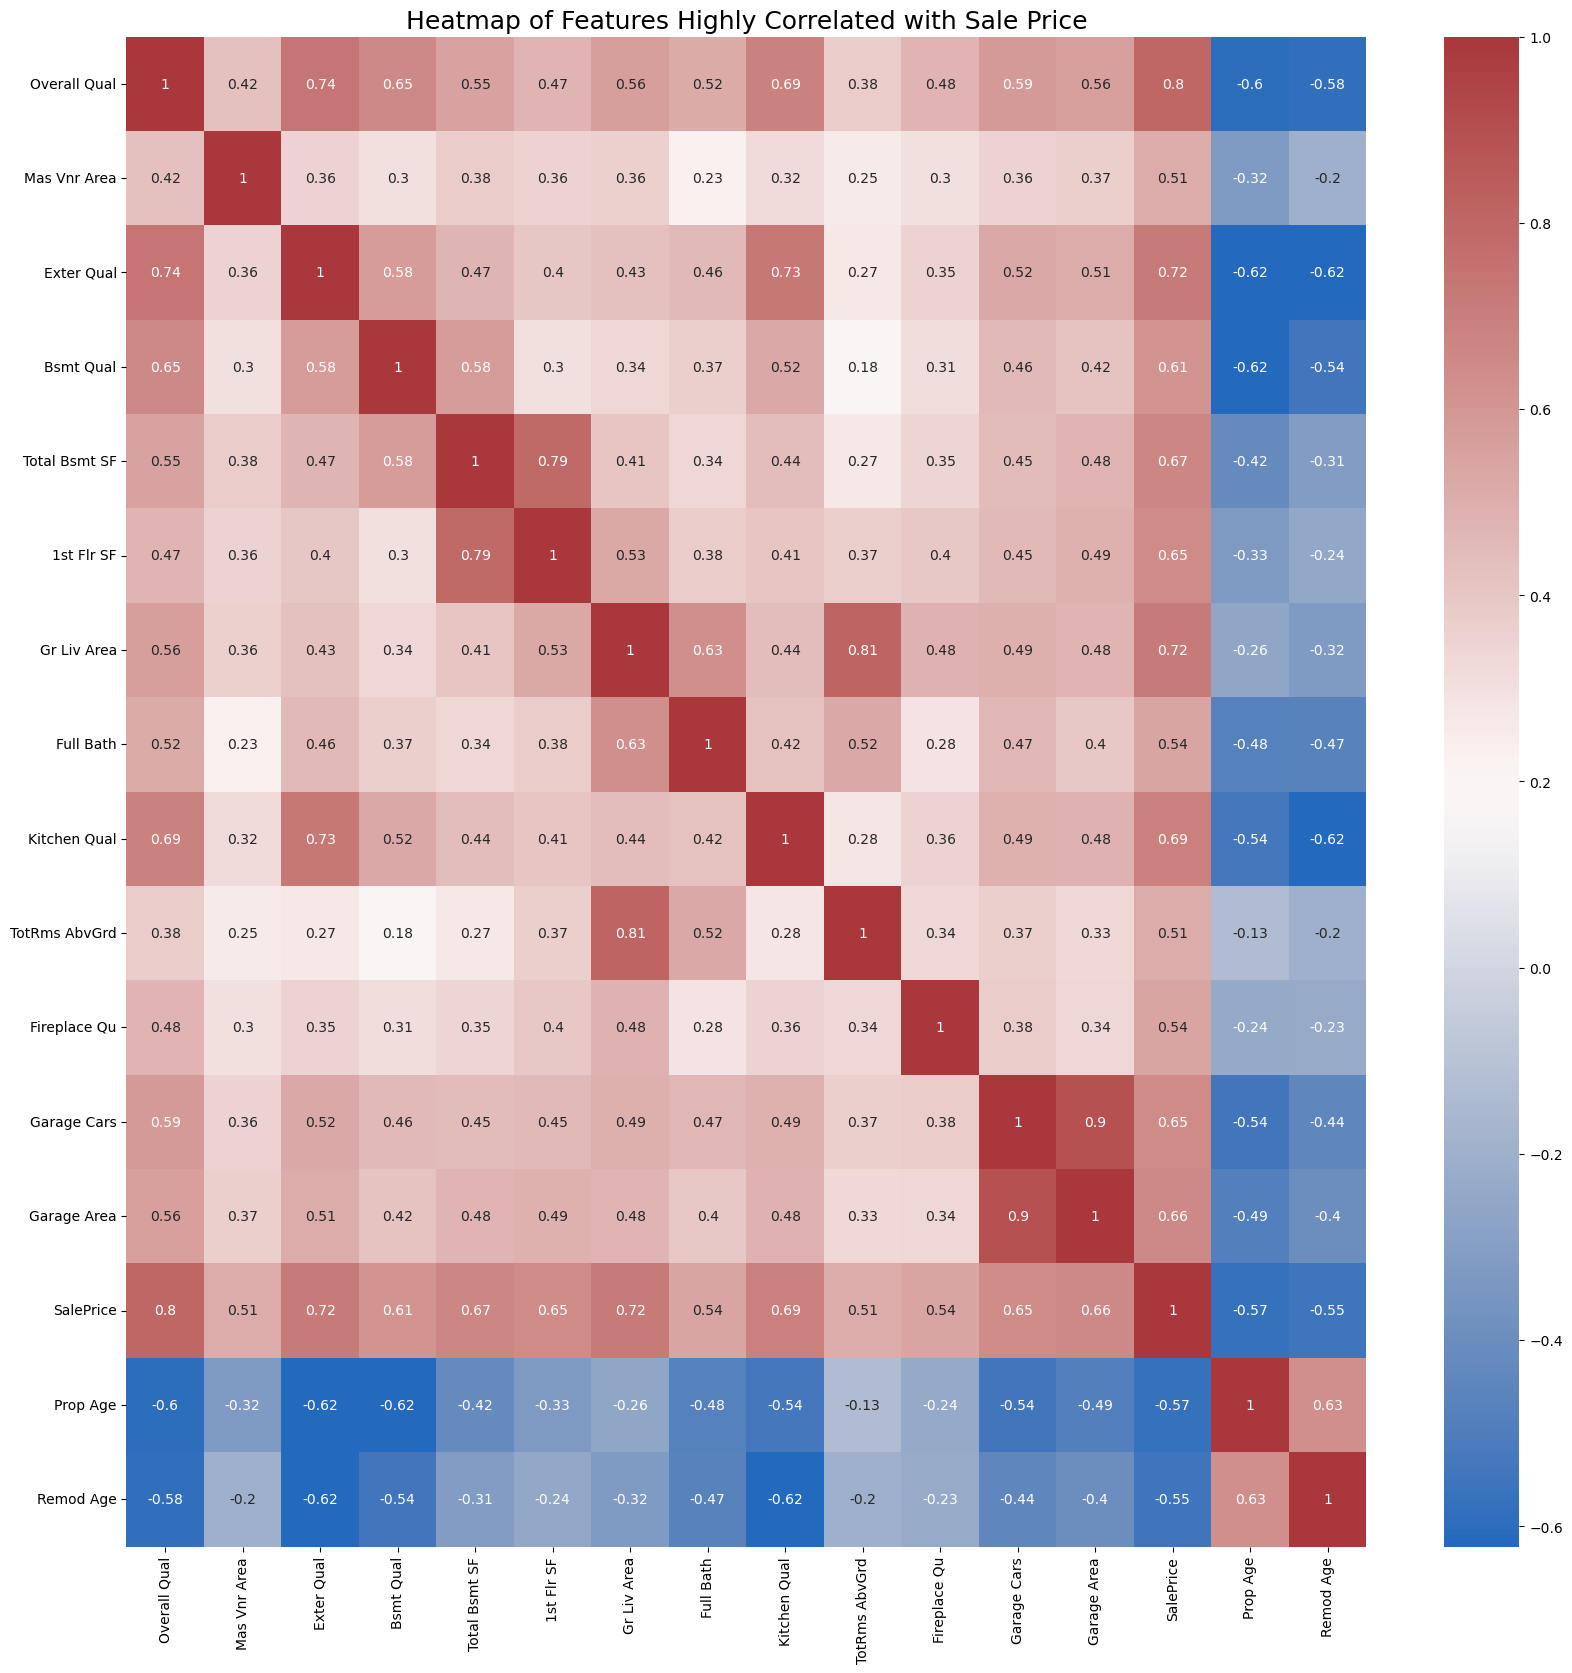

In [222]:
plt.figure(figsize=(20, 20), dpi=100)

plt.title("Heatmap of Features Highly Correlated with Sale Price", {'fontsize': 18})
sns.heatmap(df[Numeric_F].corr(), annot = True, cmap = 'vlag');

In [223]:
# remove "SalePrice" from the numerical features list

Numeric_F.remove("SalePrice")


In [224]:
df.drop(columns = ["1st Flr SF",
                   "TotRms AbvGrd",
                   "Garage Cars",
                   "Bsmt Qual",
                   "Exter Qual",
                   "Kitchen Qual"],
                    axis = 1, inplace = True)

In [225]:
df.shape

(2049, 38)

Identify and remove features that have high correlation with each other since including a group of highly correlated features will not add much additional information for the model.

(1) "1st Flr SF" vs "Total Bsmt SF"

Remove "1st Flr SF" as it has lower correlation with Sale Price

(2) "Gr Liv Area" vs "TotRms AbvGrd"

Remove "TotRms AbvGrd" as it has lower correlation with Sale Price

(3) "Garage Cars" vs "Garage Area"

Remove "Garage Cars" as it has lower correlation with Sale Price

(4) "Overall Qual" vs "Bsmt Qual" vs "Exter Qual" vs "Kitchen Qual"

Keep "Overall Qual" since it has the highest correlation with Sale Price among the group.


#### Selecting Catergorical Features

In [226]:
# List of categorical features
class_f = [df.columns[i] for i in range(0,len(df.columns)) if df[df.columns[i]].dtype == "object"]

In [227]:
len(class_f)

28

We will attempt to get an overview of the catergorical features by plotting the count plots and box plots to help narrow down features we want to keep in our regression model.

In [228]:
#subplots of barplots of all class_f

def subplot_bar(dataframe, list_of_columns, list_of_titles, list_of_xlabels,plot_title):
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(20,80))
    plt.tight_layout(h_pad = 5,pad=5);
    plt.suptitle(plot_title, fontsize=20, y=1)
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.countplot(data=dataframe, x=column, ax=ax[i], palette="vlag")
        ax[i].set_title(list_of_titles[i])# feel free to add more settings
        ax[i].set_xlabel(list_of_xlabels[i])# Set titles, labels, etc here for each subplot

In [229]:
len(df[class_f].columns)

28

In [230]:
dataframe = df
list_of_columns = df[class_f].columns
list_of_titles = df[class_f].columns
list_of_xlabels = ["values"] * 28

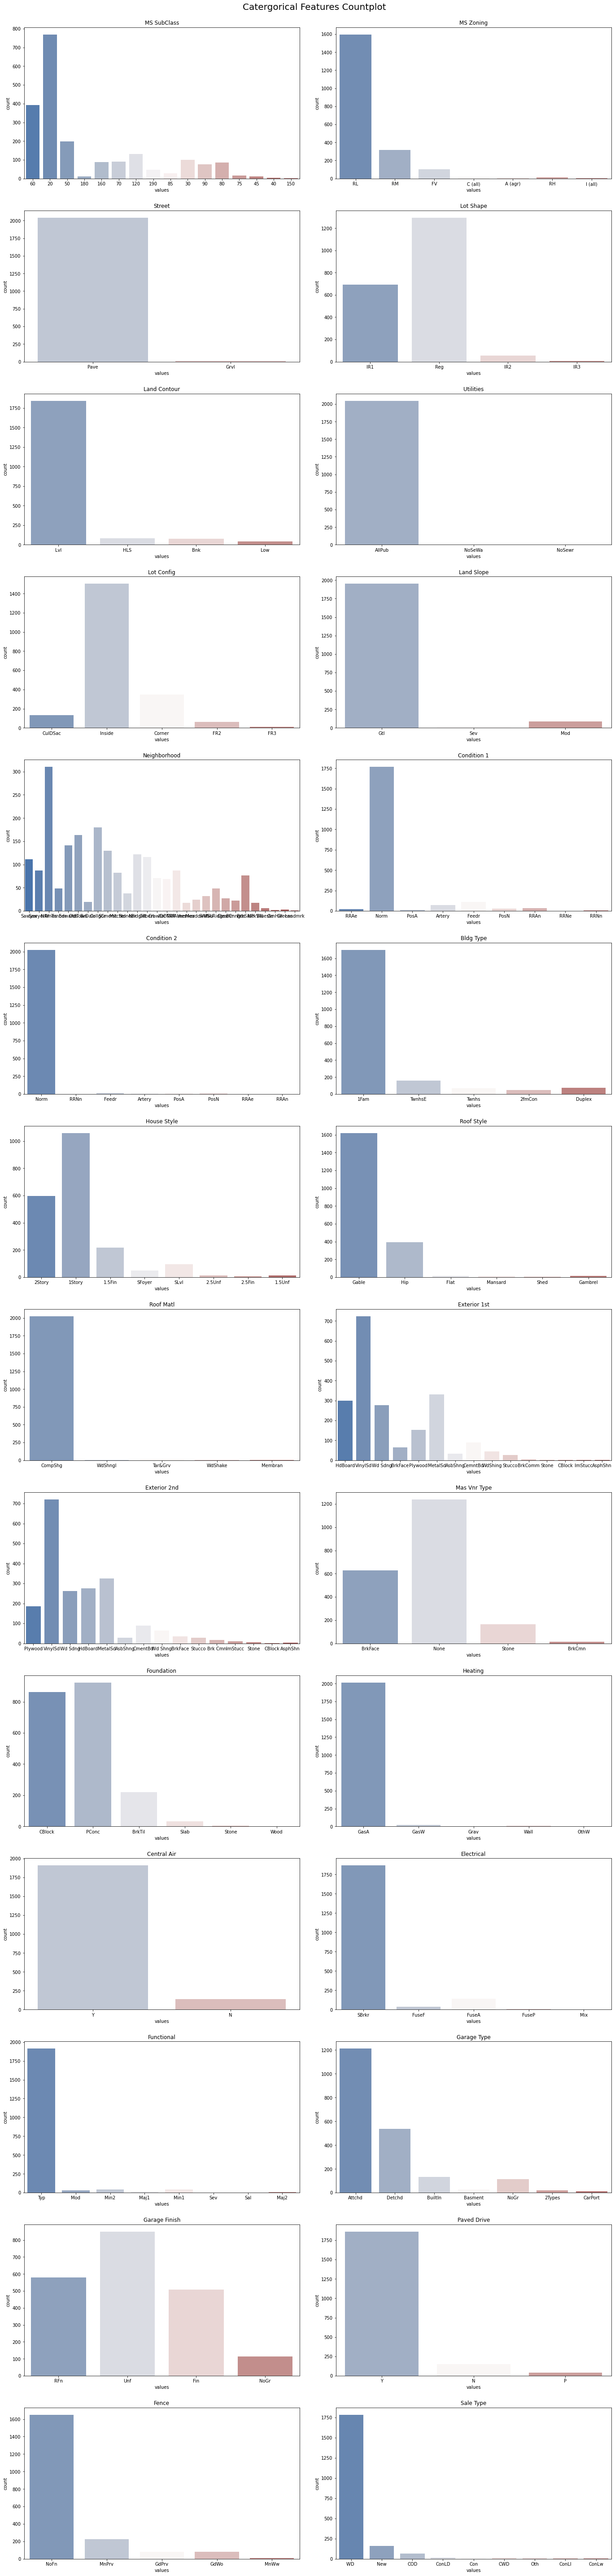

In [231]:
subplot_bar(dataframe, list_of_columns, list_of_titles, list_of_xlabels,plot_title="Catergorical Features Countplot")

In [232]:
#subplots of boxplots of all class_f

def subplot_boxp(dataframe, list_of_columns, list_of_titles, list_of_xlabels,plot_title):
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(20,80))
    plt.tight_layout(h_pad = 5,pad=5);
    plt.suptitle(plot_title, fontsize=20, y=1)
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.boxplot(data=dataframe, x=column, y=df["SalePrice"], ax=ax[i], palette="vlag" )
        ax[i].set_title(list_of_titles[i])# feel free to add more settings
        ax[i].set_xlabel(list_of_xlabels[i])# Set titles, labels, etc here for each subplot

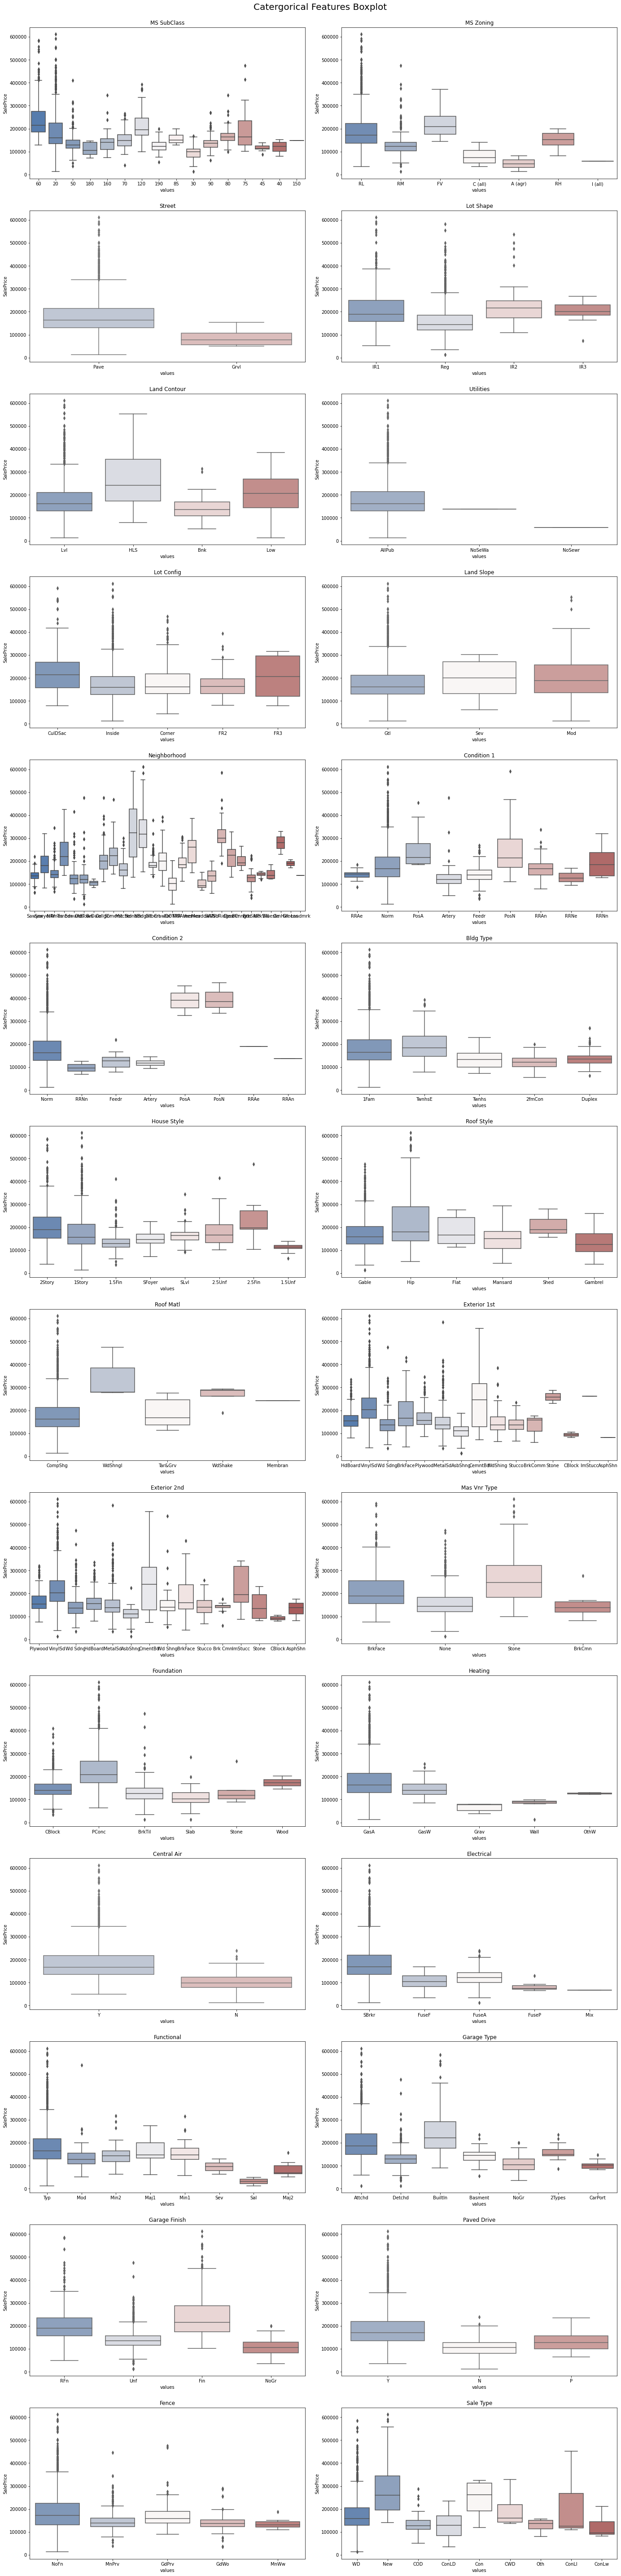

In [233]:
subplot_boxp(dataframe, list_of_columns, list_of_titles, list_of_xlabels, plot_title = "Catergorical Features Boxplot")

Zooming in on the 5 categorical features we intend to drop from the model.

In [234]:
def subplot_box_count(dataframe, y_value,
                            list_of_columns, 
                            plot_title, figsize):
    nrows = int(np.ceil(len(list_of_columns))) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, sharex=False , sharey=False, figsize = figsize)
    plt.tight_layout(h_pad = 5,pad=5);
    plt.suptitle(plot_title, fontsize=20, y=1)
    plt.xticks()
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.countplot(data=dataframe, x=column, ax=ax[i][0], palette="vlag");
        ax[i][0].set_title(f"{column}", fontsize=16, y=1.01)   # feel free to add more settings
        ax[i][0].set_xlabel(f"{column}", fontsize=12)  # Set titles, labels, etc here for each subplot
        ax[i][0].set_ylabel("Count", fontsize=12)
        
        sns.boxplot(data=dataframe, x=column, y=y_value, ax=ax[i][1], palette="vlag");
        ax[i][1].set_title(f"{column}", fontsize=16, y=1.01)   # feel free to add more settings
        ax[i][1].set_xlabel(f"{column}", fontsize=12)  # Set titles, labels, etc here for each subplot
        ax[i][1].set_ylabel(f"{y_value}", fontsize=12)

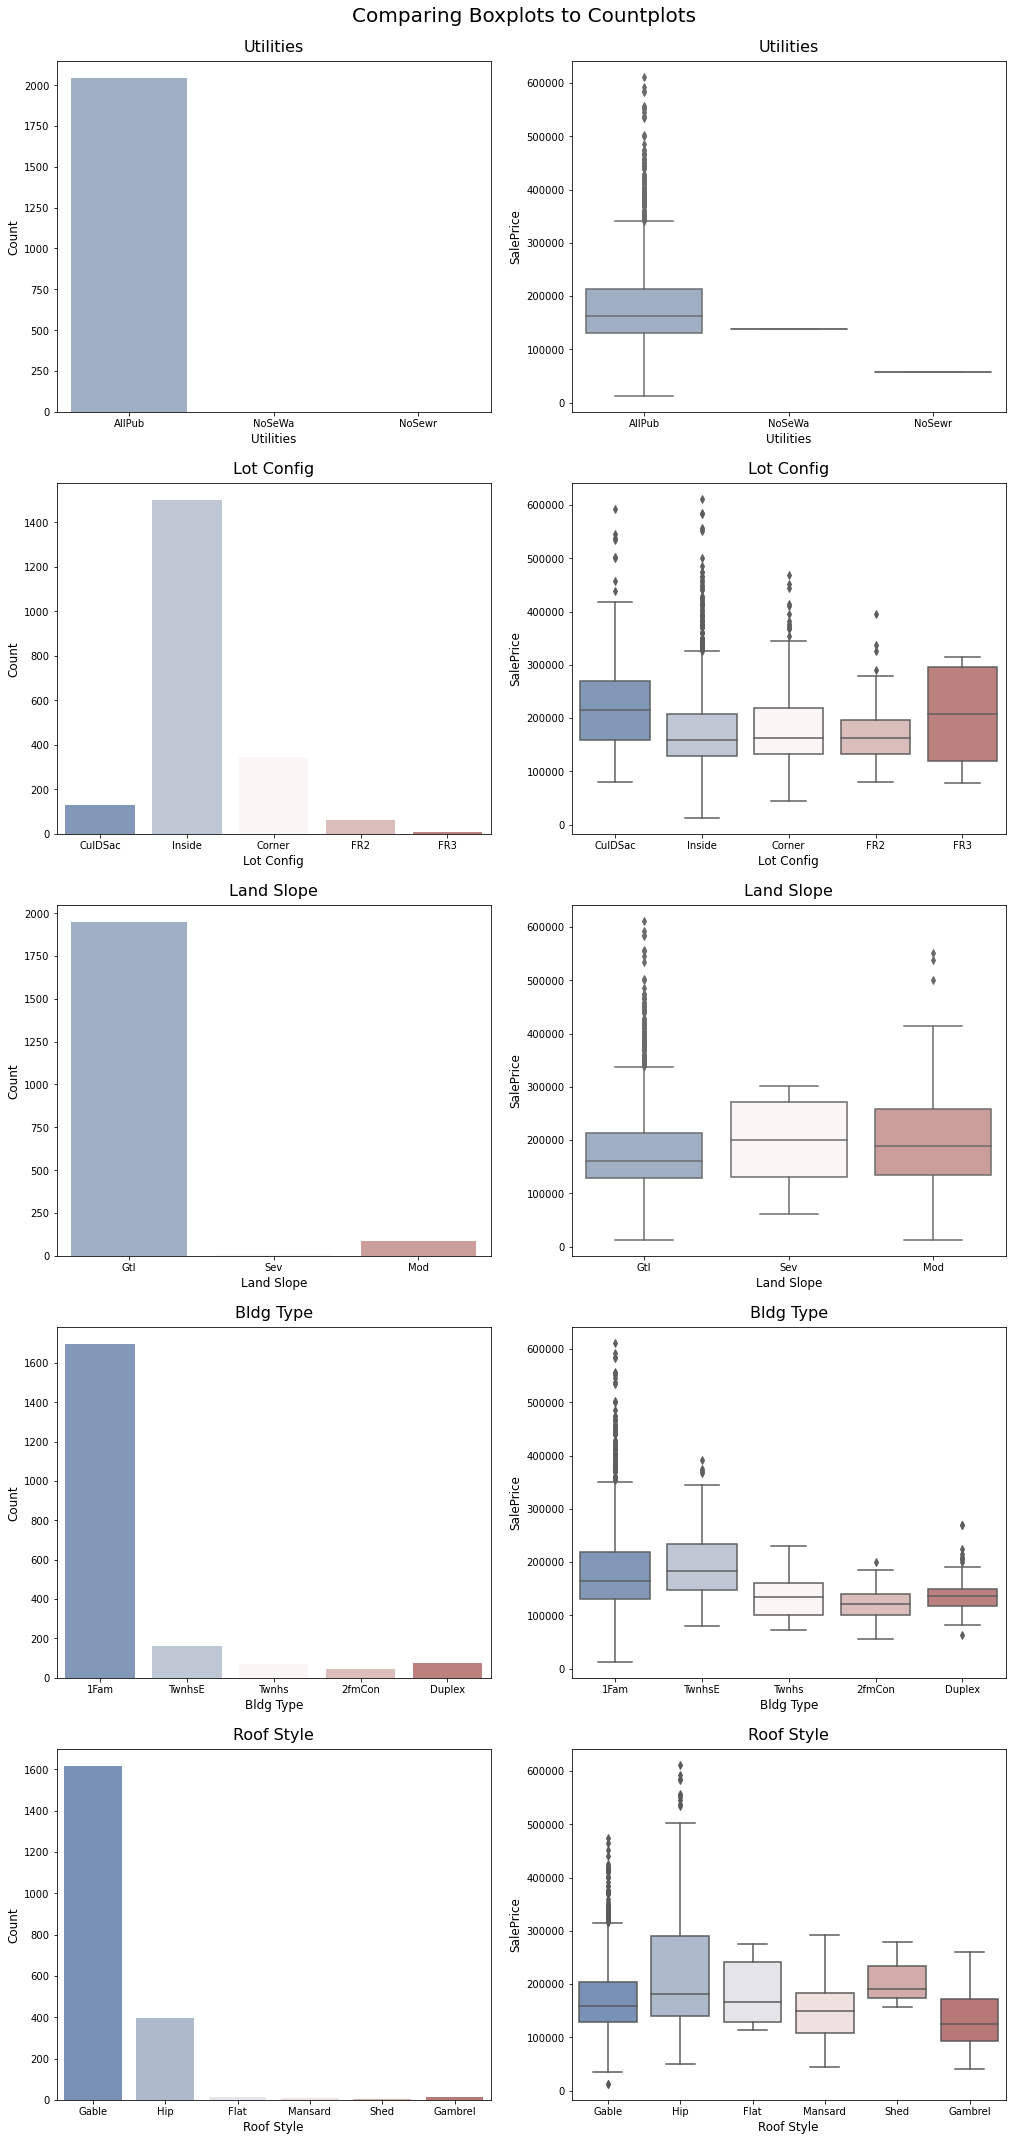

In [235]:
subplot_box_count(dataframe = df, y_value = 'SalePrice' ,
                  list_of_columns= ['Utilities','Lot Config','Land Slope','Bldg Type','Roof Style'], 
                  plot_title = "Comparing Boxplots to Countplots", 
                  figsize = (15,30) )

From the above comparisons, we observe that the five features above have very high occurence in only 1 or 2 categories within the feature. The boxplot also show limited variations among the catergories when plotted against the Sale price, therefore these may not add more predictive powers to our model and will be dropped from the model.

In [236]:
class_f = [df.columns[i] for i in range(0,len(df.columns)) if df[df.columns[i]].dtype == "object"]


In [237]:
# dropping the shortlisted catergorical features

drop_class_list = ['Utilities',
                   'Lot Config',
                   'Land Slope',
                   'Bldg Type',
                   'Roof Style']


In [238]:
df.drop(columns = drop_class_list,axis = 1, inplace = True)

In [239]:
df.shape

(2049, 33)

In [240]:
df.columns

Index(['MS SubClass', 'MS Zoning', 'Street', 'Lot Shape', 'Land Contour',
       'Neighborhood', 'Condition 1', 'Condition 2', 'House Style',
       'Overall Qual', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Foundation', 'Total Bsmt SF',
       'Heating', 'Central Air', 'Electrical', 'Gr Liv Area', 'Full Bath',
       'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish',
       'Garage Area', 'Paved Drive', 'Fence', 'Sale Type', 'SalePrice',
       'Prop Age', 'Remod Age'],
      dtype='object')

In [241]:
# Perform one hot encode for the remaining categorical features

dummies_list = [df.columns[i] for i in range(0,len(df.columns)) if df[df.columns[i]].dtype == "object"]
dummies_list

['MS SubClass',
 'MS Zoning',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'House Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Electrical',
 'Functional',
 'Garage Type',
 'Garage Finish',
 'Paved Drive',
 'Fence',
 'Sale Type']

In [242]:
# one hot encode the nominal and ordinal features
df = pd.get_dummies(df, columns = dummies_list, drop_first = True)

In [243]:
df.shape

(2049, 166)

In [244]:
X = df.drop(columns = "SalePrice",axis=1)
y = df["SalePrice"]

X = sm.add_constant(X, prepend=True)
results = sm.OLS(y, X).fit()

In [245]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     105.6
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        03:13:58   Log-Likelihood:                -23643.
No. Observations:                2049   AIC:                         4.762e+04
Df Residuals:                    1884   BIC:                         4.854e+04
Df Model:                         164                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.321e+05   4.12e+04     -3.205      0.001   -2.13e+05   -5.13e+04
Overall Qual          1.068e+04    857.584     12.450      0.000    8995.419    1.24e+04
Mas Vnr Area            44.6417      5.466      8.167      0.000      33.922      55.362
Total Bsmt SF           31.0677      2.871     10.821      0.000      25.437      36.699
Gr Liv Area             57.0872      3.010     18.965      0.000      51.184      62.991
Full Bath            -4085.9149   1754.909     -2.328      0.020   -7527.685    -644.145
Fireplace Qu          1595.7596    441.149      3.617      0.000     730.567    2460.952
Garage Area             41.8170      4.841      8.639      0.000      32.323      51.311
Prop Age              -253.1777     67.261     -3.764      0.000    -385.091    -121.265
Remod Age             -330.7396     44.818     -7.380      0.000    -418.637    -242.842
MS SubClass_150      -2.896e+04   2.89e+04     -1.004      0.316   -8.56e+04    2.76e+04
MS SubClass_160        361.4984   8113.112      0.045      0.964   -1.56e+04    1.63e+04
MS SubClass_180      -3518.1844   1.23e+04     -0.286      0.775   -2.77e+04    2.06e+04
MS SubClass_190        2.14e+04   6932.387      3.087      0.002    7803.456     3.5e+04
MS SubClass_20        2.798e+04   3394.052      8.243      0.000    2.13e+04    3.46e+04
MS SubClass_30        3.316e+04   5281.136      6.279      0.000    2.28e+04    4.35e+04
MS SubClass_40         3.02e+04   1.45e+04      2.087      0.037    1817.102    5.86e+04
MS SubClass_45        3.825e+04   1.91e+04      2.008      0.045     885.912    7.56e+04
MS SubClass_50        2.222e+04   8998.260      2.470      0.014    4574.398    3.99e+04
MS SubClass_60        2.848e+04   7284.492      3.909      0.000    1.42e+04    4.28e+04
MS SubClass_70        3.178e+04   7849.781      4.048      0.000    1.64e+04    4.72e+04
MS SubClass_75        3.887e+04   1.45e+04      2.681      0.007    1.04e+04    6.73e+04
MS SubClass_80        8939.2824   1.21e+04      0.738      0.461   -1.48e+04    3.27e+04
MS SubClass_85        2.184e+04   9997.496      2.184      0.029    2230.275    4.14e+04
MS SubClass_90       -2827.2674   5881.660     -0.481      0.631   -1.44e+04    8707.985
MS Zoning_C (all)     4880.7397   3.27e+04      0.149      0.882   -5.93e+04    6.91e+04
MS Zoning_FV          3.111e+04   3.23e+04      0.963      0.336   -3.23e+04    9.45e+04
MS Zoning_I (all)     4.456e+04   4.33e+04      1.030      0.303   -4.03e+04    1.29e+05
MS Zoning_RH          1.682e+04   3.29e+04      0.511      0.609   -4.77e+04    8.13e+04
MS Zoning_RL          1.659e+04   3.18e+04      0.522      0.601   -4.57e+04    7.89e+04
MS Zoning_RM          1.323e+04   3.19e+04      0.415      0.678   -4.93e+04    7.58e+04
Street_Pave          -1832.0506   1.19e+04     -0.154    

<br />
<br />
We observe from the OLS regression results the the p-value of F-Statistic is less than 0.01, which suggest that at least one feature in our model can help to predict the sale price. We do also observe many features in the model with p-value of t-statistic smaller than 0.05 which implies their correlation with sale price. We are confident we have more than enough features in our regression model.

In [246]:
# Applying the necessary changes to the test.csv for kaggle submission

kaggle = pd.read_csv('./datasets/test.csv')

In [247]:
kaggle.drop(["Alley","Pool QC", "Misc Feature"],axis=1, inplace = True)

In [248]:
kaggle["Lot Frontage"].fillna(0.0, inplace = True)
kaggle["Mas Vnr Type"].fillna("None", inplace = True)
kaggle["Mas Vnr Area"].fillna(0.0, inplace = True)
kaggle['Bsmt Qual'].fillna("NoBase", inplace = True)
kaggle['Bsmt Cond'].fillna("NoBase", inplace = True)
kaggle['BsmtFin Type 1'].fillna("NoBase", inplace = True)
kaggle['Bsmt Exposure'] = np.where((kaggle['Bsmt Qual'] != "NoBase") & 
                               (kaggle['Bsmt Exposure'].isnull() == True), 
                               "No", kaggle['Bsmt Exposure'])
kaggle['Bsmt Exposure'].fillna("NoBase", inplace = True)
kaggle['BsmtFin Type 2'] = np.where((kaggle['Bsmt Qual'] != "NoBase") & 
                             (kaggle['BsmtFin Type 2'].isnull() == True), 
                             "Unf", kaggle['BsmtFin Type 2'])
kaggle['BsmtFin Type 2'].fillna("NoBase", inplace = True)
kaggle['BsmtFin SF 1'].fillna(0.0, inplace = True)
kaggle['BsmtFin SF 2'].fillna(0.0, inplace = True)
kaggle['Bsmt Unf SF'].fillna(0.0, inplace = True)
kaggle['Total Bsmt SF'].fillna(0.0, inplace = True)
kaggle['Bsmt Full Bath'].fillna(0.0, inplace = True)
kaggle['Bsmt Half Bath'].fillna(0.0, inplace = True)
kaggle['Fireplace Qu'].fillna("NoFP", inplace = True)
kaggle["Garage Cars"].fillna(0.0, inplace = True)
kaggle["Garage Area"].fillna(0.0, inplace = True)
kaggle['Garage Yr Blt'].fillna(0.0, inplace = True)
kaggle['Garage Type'].fillna("NoGr", inplace = True)
kaggle['Garage Finish'].fillna("NoGr", inplace = True)
kaggle['Garage Qual'].fillna("NoGr", inplace = True)
kaggle['Garage Cond'].fillna("NoGr", inplace = True)
kaggle['Fence'].fillna("NoFn", inplace = True)

In [249]:
kaggle["MS SubClass"] = kaggle["MS SubClass"].astype(str)

In [250]:
map_to_num(kaggle,["Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond","Heating QC",
"Kitchen Qual","Garage Qual", "Garage Cond", "Fireplace Qu"])

In [251]:
kaggle['Bsmt Exposure'] = kaggle['Bsmt Exposure'].map({"Gd":4, 
                                               "Av":3, 
                                               "Mn":2, 
                                               "No":1, 
                                               "NoBase":0})

In [252]:
kaggle['BsmtFin Type 1'] = kaggle['BsmtFin Type 1'].map({"GLQ":6, 
                                               "ALQ":5, 
                                               "BLQ":4, 
                                               "Rec":3, 
                                               "LwQ":2, 
                                               "Unf":1, 
                                               "NoBase":0})

kaggle['BsmtFin Type 2'] = kaggle['BsmtFin Type 2'].map({"GLQ":6, 
                                               "ALQ":5, 
                                               "BLQ":4, 
                                               "Rec":3, 
                                               "LwQ":2, 
                                               "Unf":1, 
                                               "NoBase":0})

In [253]:
kaggle["Prop Age"] = 2022 - kaggle['Year Built']
kaggle["Remod Age"] = 2022 - kaggle['Year Remod/Add']
kaggle["Garage Age"] = 2022 - kaggle['Garage Yr Blt']

In [254]:
kaggle.drop(columns = ['Year Built','Year Remod/Add','Garage Yr Blt'],axis = 1, inplace = True)

In [255]:
kaggle.drop(columns = ["1st Flr SF",
                   "TotRms AbvGrd",
                   "Garage Cars",
                   "Bsmt Qual",
                   "Exter Qual",
                   "Kitchen Qual"],
                    axis = 1, inplace = True)

In [256]:
drop_list = drop_numeric_list + drop_class_list
drop_list.remove('Id')

In [257]:
# dropping features that have been dropped in train dataset

kaggle.drop(columns = drop_list, axis = 1, inplace = True)
kaggle.shape

(878, 33)

In [258]:
kaggle = pd.get_dummies(kaggle, columns = dummies_list, drop_first = True)
kaggle.shape

(878, 155)

## Preprocessing and Modeling
---

In [259]:
# Finding intersection of features in the train and test datasets

cols_intersec = set(df.columns).intersection(set(kaggle.columns))

In [260]:
X = df[list(cols_intersec)]
X_kaggle = kaggle[list(cols_intersec)]

In [261]:
# checking that the number of columns are consistent

X.shape,X_kaggle.shape

((2049, 146), (878, 146))

In [262]:
# Setting up X and y for modelling

X = df[list(cols_intersec)]
y = df['SalePrice']

In [263]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [264]:
# Scaling our data for both train and test dataset

ss = StandardScaler()

Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)
X_kaggle = ss.transform(X_kaggle)

### Baseline Model

We will first construct a baseline model simply by using the mean sale price of our train data as our prediction. This baseline serves as the "best guess" model without considering any of the features provided in the dataset.

In [265]:
y_pred = y_train.mean()
y_pred

182104.22635753508

In [266]:
resids = y_test - y_pred

In [267]:
mse = np.mean(resids**2)
mse

5974752814.486461

In [268]:
rmse = np.sqrt(mse)
rmse

77296.52524199558

### Linear Regression

In [269]:
lr = LinearRegression()

lr.fit(Z_train,y_train)

LinearRegression()

In [270]:
lr.score(Z_train,y_train)

0.8995595525189204

In [271]:
lr.score(Z_test,y_test)

0.8823296064713086

In [272]:
cross_val_score(lr,Z_train,y_train,cv=5).mean()

-4.957831558694232e+23

In [273]:
lr_nmse = cross_val_score(lr,Z_train,y_train,scoring='neg_mean_squared_error',cv=5).mean()
lr_nmse

-2.582379628507561e+33

In [274]:
lr_rmse = np.sqrt(-lr_nmse)
lr_rmse

5.081711944323055e+16

### Ridge Regularization Model

In [275]:
# deriving the optimal alpha value for our Ridge model

r_alphas = np.logspace(0,5,100)

ridge_cv = RidgeCV(alphas = r_alphas, cv=5)

ridge_cv.fit(Z_train,y_train);

In [276]:
print(ridge_cv.alpha_)

52.14008287999685


In [277]:
# Instantiating our Ridge Model with the opitmal alpha value
ridge = Ridge(alpha = ridge_cv.alpha_)

In [278]:
ridge.fit(Z_train,y_train)

Ridge(alpha=52.14008287999685)

In [279]:
ridge.score(Z_train,y_train)

0.8974106673099408

In [280]:
ridge.score(Z_test,y_test)

0.880813953253283

In [281]:
ridge_scores = cross_val_score(ridge,Z_train,y_train, cv =5)
ridge_scores.mean()

0.8704322263476344

In [282]:
ridge_nmse = cross_val_score(ridge,Z_train,y_train,scoring='neg_mean_squared_error',cv=10).mean()

In [283]:
ridge_rmse = np.sqrt(-ridge_nmse)
ridge_rmse

28339.547195442876

### Lasso Regularization Model

In [284]:
# deriving the optimal alpha value for our Lasso model
lasso_cv = LassoCV(n_alphas = 100, cv=5, max_iter=50000)
lasso_cv.fit(Z_train, y_train)
print(lasso_cv.alpha_)

394.1073737570465


In [285]:
# Instantiating our Ridge Model with the opitmal alpha value
lasso = Lasso(alpha = lasso_cv.alpha_)

In [286]:
lasso.fit(Z_train,y_train)

Lasso(alpha=394.1073737570465)

In [287]:
lasso.score(Z_train,y_train)

0.8922752088693374

In [288]:
lasso.score(Z_test,y_test)

0.878610860359641

In [289]:
cross_val_score(lasso,Z_train,y_train,cv=5).mean()

0.8721183061438162

In [290]:
lasso_nmse = cross_val_score(lasso,Z_train,y_train,scoring='neg_mean_squared_error',cv=10).mean()

In [291]:
lasso_rmse = np.sqrt(-lasso_nmse)
lasso_rmse

28173.326062898806

## Evaluation
---

In this section we will compare the various models with the baseline model and make a selection base on their performance.

### Model Comparison Table

|        Model Type | Cross Val Score | Train |  Test |      RMSE |      α |
|------------------:|----------------:|------:|------:|----------:|-------:|
| Base Model (Mean) | NA              | NA    | NA    | 77296.53  | NA     |
| Linear Regression |      -4.028e+22 | 0.900 | 0.882 | 1.461e+16 |     NA |
|       Ridge Model |           0.870 | 0.897 | 0.881 |  28339.55 |  52.14 |
|       Lasso Model |           0.872 | 0.892 | 0.879 |  28173.42 | 394.12 |

### Top Features in Ridge and Lasso Model

|    | **Ridge Model Features** | **Absolute coef** | **Lasso Model Features** | **Absolute coef** |
|---:|-------------------------:|------------------:|-------------------------:|------------------:|
|  1 |              Gr Liv Area |      24235.069243 |              Gr Liv Area |      27075.970103 |
|  2 |             Overall Qual |      14692.860819 |             Overall Qual |      16421.239136 |
|  3 |            Total Bsmt SF |      13255.270896 |            Total Bsmt SF |      11744.972113 |
|  4 |           MS SubClass_20 |       8805.940788 |     Neighborhood_NridgHt |       8086.166642 |
|  5 |              Garage Area |       8325.112076 |              Garage Area |       7164.533261 |
|  6 |             Mas Vnr Area |       7463.643542 |             Mas Vnr Area |       6991.376686 |
|  7 |     Neighborhood_NridgHt |       7228.967847 |                Remod Age |       6205.456312 |
|  8 |                 Prop Age |       6506.338406 |                 Prop Age |       5784.698415 |
|  9 |                Remod Age |       6417.992318 |     Neighborhood_StoneBr |       5698.449658 |
| 10 |            Sale Type_New |       6337.496198 |           MS SubClass_20 |       5629.266237 |

When we look at the train and test R² score for our linear regression model, it may seem we have a winner as it achieved a relatively high train score of 90% and a slightly lower 88% test score. However after conducting a 5 fold cross validation it reveals it weakness by returning a RMSE of 1.461e+16 which is significantly higher than that from our baseline model. This shows the Linear Regression model grossly oversimplifies the data and has a very high bias.

Both Ridge and Lasso model score very similarly across the various metric with the Lasso model acheiving slightly better RMSE result of 28173.42. When consulting the top 10 features (by highest absolute coefficient value) of both model, we see that they share 9 common features in their top 10 list, in fact the top 3 features and ranking are exactly the same for both model. The commonality in features used and their weightage may help to explain the similarity in their performance.

Thus having considered the above, we will select the **lasso model** as our model of choice as the lasso model helps to reduce the number of features used from 146 to 86 which reduced complexity with little compromise on performance.



In [292]:
r_features = [col for col in X.columns if col != "SalePrice"]

df2 = pd.DataFrame({"features": r_features,"coef":abs(ridge.coef_)})

In [293]:
# Top 10 features in Ridge Model

df2[abs(df2['coef']) > 0].sort_values(by = 'coef', ascending = False).head(10)

,features,coef
91,Gr Liv Area,24235.069243
24,Overall Qual,14692.860819
118,Total Bsmt SF,13255.270896
90,MS SubClass_20,8805.940788
47,Garage Area,8325.112076
117,Mas Vnr Area,7463.643542
30,Neighborhood_NridgHt,7228.967847
100,Prop Age,6506.338406
51,Remod Age,6417.992318
32,Sale Type_New,6337.496198


In [294]:
# Total number of features in Ridge model remains unchanged
df2[abs(df2['coef']) > 0].count()

features    146
coef        146
dtype: int64

In [295]:
l_features = [col for col in X.columns if col != "SalePrice"]

df3 = pd.DataFrame({"features": l_features,"coef":abs(lasso.coef_)})

In [296]:
df3[abs(df3['coef']) > 0].sort_values(by = 'coef', ascending = False).head(10)

,features,coef
91,Gr Liv Area,27076.266735
24,Overall Qual,16421.283504
118,Total Bsmt SF,11745.491781
30,Neighborhood_NridgHt,8085.949608
47,Garage Area,7163.748676
117,Mas Vnr Area,6990.920647
51,Remod Age,6202.814998
100,Prop Age,5791.225745
37,Neighborhood_StoneBr,5698.112011
90,MS SubClass_20,5625.777013


In [297]:
df3[abs(df3['coef']) > 0].count()

features    86
coef        86
dtype: int64

In [298]:
df3.sort_values(by = 'coef', ascending = False).head(10)

,features,coef
91,Gr Liv Area,27076.266735
24,Overall Qual,16421.283504
118,Total Bsmt SF,11745.491781
30,Neighborhood_NridgHt,8085.949608
47,Garage Area,7163.748676
117,Mas Vnr Area,6990.920647
51,Remod Age,6202.814998
100,Prop Age,5791.225745
37,Neighborhood_StoneBr,5698.112011
90,MS SubClass_20,5625.777013


In [299]:
lasso_coef_df = pd.DataFrame(data=lasso.coef_, index=X_train.columns, columns=['lasso_coef'])
lasso_coef_df

,lasso_coef
Neighborhood_Gilbert,-1601.143329
Exterior 1st_BrkFace,3088.102567
MS Zoning_FV,1206.358732
Lot Shape_IR3,-906.957134
House Style_SLvl,2695.626132
...,...
Exterior 1st_VinylSd,0.000000
Neighborhood_BrkSide,1145.705814
Neighborhood_Veenker,572.939868
Neighborhood_Blueste,-94.251162


In [300]:
lasso_coef_df = lasso_coef_df.sort_values(by='lasso_coef', ascending=False)
lasso_coef_df

,lasso_coef
Gr Liv Area,27076.266735
Overall Qual,16421.283504
Total Bsmt SF,11745.491781
Neighborhood_NridgHt,8085.949608
Garage Area,7163.748676
...,...
Mas Vnr Type_BrkFace,-2306.091517
MS SubClass_90,-2552.363107
Garage Finish_RFn,-3823.321439
Prop Age,-5791.225745


In [301]:
lasso_coef_df = lasso_coef_df[lasso_coef_df['lasso_coef'] != 0]

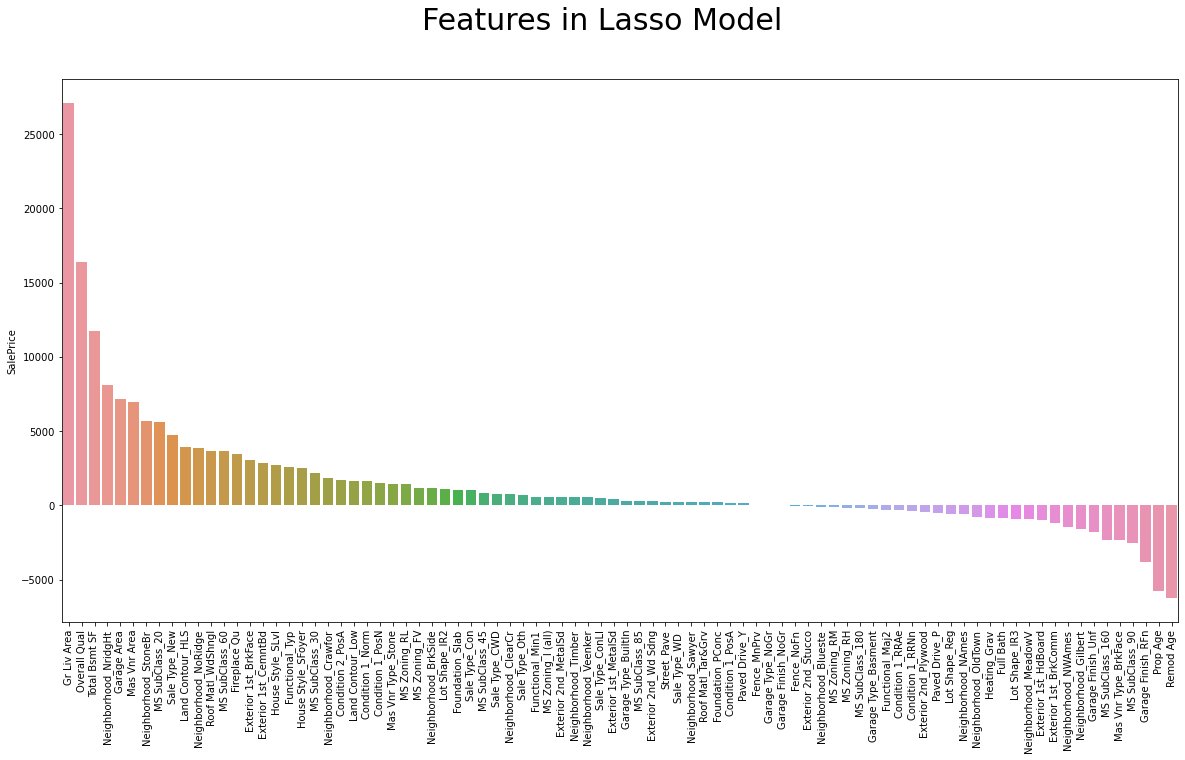

In [302]:
plt.figure(figsize=(20, 10))
plt.suptitle("Features in Lasso Model", size=30)
plt.ylabel("SalePrice")
plt.xticks(rotation=90)
sns.barplot(data=lasso_coef_df.T);

**Intepretation of top 5 features in Lasso Model**

1. Gr Liv Area - A 1 square feet increase in above ground living area can increase the sale price by $27076.
2. Overall Qual - A 1 grade increase in overall quality rating can increase the sale price by \$16421.
3. Total Bsmt SF - A 1 square feet increase in total basement are can increase the sale price by \$11745.
4. Neighborhood_NridgHt - If the property is located in the Northridge Heights neighborhood, the sale price can increase by \$8086.
5. Garage Area - A 1 square feet increase in garage are can increase the sale price by \$7165.

### Prediction for Kaggle

In [303]:
preds = lasso.predict(X_kaggle)

In [304]:
new = zip(kaggle['Id'],preds)

In [305]:
new = pd.DataFrame(new,columns = ["Id","SalePrice"])

In [306]:
new.shape

(878, 2)

In [307]:
new.to_csv("./datasets/HM_Sub.csv",index=False)

## Conclusion and Recommendations
---

In conclusion, the tech team will recommend to build a **price recommender function** for AgentAmes.com website and app based on the **lasso regression model**. Since it requires less features compared to the other models, it translates to **ease of use** for our users as it also means they need to provide us with less information in order to get a reasonably good price prediction.

When seller's list their property with a price that is not too far off the market rate, it is more likely to attract bidders and in turn increases the chance of a successful sale. With more sales conducted through our platform, it will solidify AgentAmes.com's reputation as a effective platform for sellers and buyer of properties.


### Future Developments and Improvements

AgentAmes should continue collecting data from the property transactions and try to discover more features that will help to predict final sale price. While the current model does a good job, it is still quite heavily dependant on features related to size of the property.

We can also work toward further reducing the complexity of the model to make it even easier for our users to take advantage of our price prediction model. With lesser required data to furnish, it also increases the chance of the model making good price prediction. 